In [682]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [933]:
df =  pd.read_csv('diabetic_data.csv')

In [934]:
df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

In [935]:
# replacing ? with null
df = df.replace('?',np.nan)

In [936]:
df.isna().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [937]:
#dropping weight, payer_code, medical speciality as the number of null values is very high

df = df.drop(['weight','payer_code','medical_specialty'],axis=1)

In [938]:
df.drop(['encounter_id','patient_nbr'],axis=1,inplace = True)

## Target Column

In [939]:
df['readmitted<30'] = df['readmitted'].replace('>30','NO')

## Features

#### admission_type_id

In [940]:
df['admission_type_id']= df['admission_type_id'].astype('object')
df['admission_type_id']=df['admission_type_id'].replace(to_replace=[1,2,3,4,5,6,7,8],value=['Emergency','Urgent','Elective','Newborn','Not Available','NULL','Truama Center','Not Mapped'])
df['admission_type_id'].value_counts()

Emergency        53990
Elective         18869
Urgent           18480
NULL              5291
Not Available     4785
Not Mapped         320
Truama Center       21
Newborn             10
Name: admission_type_id, dtype: int64

In [941]:
pd.crosstab(df['admission_type_id'],df['readmitted<30']).sort_values('<30',ascending=False)

readmitted<30       <30     NO
admission_type_id             
Emergency          6221  47769
Urgent             2066  16414
Elective           1961  16908
NULL                586   4705
Not Available       495   4290
Not Mapped           27    293
Newborn               1      9
Truama Center         0     21

In [942]:
#Trauma center is another medical term for emergency
#Clubbing 'NULL','Not Available','Not Mapped'.

df['admission_type_id'] = df['admission_type_id'].replace('Truama Center','Emergency')
df['admission_type_id'] = df['admission_type_id'].replace(['NULL','Not Available','Not Mapped','Newborn'],['Others','Others','Others','Others'])  
#df['admission_type_id'] = df['admission_type_id'].replace(['Newborn','Truama Center'],['Misc','Misc'])  
df['admission_type_id'].value_counts()

Emergency    54011
Elective     18869
Urgent       18480
Others       10406
Name: admission_type_id, dtype: int64

In [943]:
pd.crosstab(df['admission_type_id'],df['readmitted<30']).sort_values('<30',ascending=False)

readmitted<30       <30     NO
admission_type_id             
Emergency          6221  47790
Urgent             2066  16414
Elective           1961  16908
Others             1109   9297

In [944]:
from scipy.stats import chi2_contingency
def chisq_test(ct_df):
    num_rows = ct_df.shape[0]
    l = []
    for i in range(num_rows):
        val = ct_df.iloc[i,:].values
        l.append(val)
    
    chisq_test_array = np.array(l)
    chisq_test_result = chi2_contingency(chisq_test_array)
    print('Feature Name: ',ct_df.index.name)
    print('\n---------------------\n')
    print(chisq_test_result)
    print('\n---------------------\n')
    print('P-value: ',chisq_test_result[1])
    if (chisq_test_result[1]<0.05):
        print('\n==>>',ct_df.index.name,' is a good feature for predicting readmission')
    else:
        print('\n==>>',ct_df.index.name,' is NOT a good feature for predicting readmission')

In [945]:
chisq_test(pd.crosstab(df['admission_type_id'],df['readmitted<30']))

Feature Name:  admission_type_id

---------------------

(20.847047264157705, 0.00011326338567822017, 3, array([[ 2105.76452843, 16763.23547157],
       [ 6027.5821689 , 47983.4178311 ],
       [ 1161.30084704,  9244.69915296],
       [ 2062.35245563, 16417.64754437]]))

---------------------

P-value:  0.00011326338567822017

==>> admission_type_id  is a good feature for predicting readmission


#### admission_source_id

In [946]:
i=1
for col in ['Physician Referral',
'Clinic Referral',
'HMO Referral',
'Transfer from a hospital',
'Transfer from a Skilled Nursing Facility (SNF)',
'Transfer from another health care facility',
'Emergency Room',
'Court/Law Enforcement',
'Not Available',
'Transfer from critial access hospital',
'Normal Delivery',
'Premature Delivery',
'Sick Baby',
'Extramural Birth',
'Not Available',
'dummy',
'NULL',
'Transfer From Another Home Health Agency',
'Readmission to Same Home Health Agency',
'Not Mapped',
'Unknown/Invalid',
'Transfer from hospital inpt/same fac reslt in a sep claim',
'Born inside this hospital',
'Born outside this hospital',
'Transfer from Ambulatory Surgery Center',
'Transfer from Hospice']:
        df['admission_source_id'] = df['admission_source_id'].replace(to_replace=i,value=col)
        i+=1

In [947]:
df['admission_source_id'].value_counts()

Emergency Room                                               57494
Physician Referral                                           29565
NULL                                                          6781
Transfer from a hospital                                      3187
Transfer from another health care facility                    2264
Clinic Referral                                               1104
Transfer from a Skilled Nursing Facility (SNF)                 855
HMO Referral                                                   187
Not Mapped                                                     161
Not Available                                                  125
Court/Law Enforcement                                           16
Transfer from hospital inpt/same fac reslt in a sep claim       12
Transfer from critial access hospital                            8
Transfer from Ambulatory Surgery Center                          2
Normal Delivery                                               

In [949]:
pd.crosstab(df['admission_source_id'],df['readmitted<30']).sort_values('<30',ascending=False)

readmitted<30                                        <30     NO
admission_source_id                                            
Emergency Room                                      6720  50774
Physician Referral                                  3130  26435
NULL                                                 706   6075
Transfer from a hospital                             309   2878
Transfer from another health care facility           212   2052
Clinic Referral                                      111    993
Transfer from a Skilled Nursing Facility (SNF)       101    754
HMO Referral                                          29    158
Not Mapped                                            22    139
Not Available                                         13    112
Court/Law Enforcement                                  2     14
Transfer from hospital inpt/same fac reslt in a...     2     10
Sick Baby                                              0      1
Transfer from Ambulatory Surgery Center                0      2
Normal Delivery                                        0      2
Extramural Birth                                       0      2
Transfer from critial access hospital                  0      8

In [950]:
replace = ['Transfer From Another Home Health Agency',
           'Transfer from a hospital',
           'Transfer from another health care facility',
           'Transfer from a Skilled Nursing Facility (SNF)',
           'Transfer from critial access hospital',
           'Transfer from Hospice',
           'Transfer from Ambulatory Surgery Center',
           'Transfer from hospital inpt/same fac reslt in a sep claim',
           'Physician Referral',
           'Clinic Referral',
           'HMO Referral',
           'Unknown/Invalid',
           'Not Available',
           'Court/Law Enforcement',
           'Normal Delivery',
           'Extramural Birth',
           'Sick Baby',
          'Not Mapped',
          'NULL']
replace_with = ['Transfer','Transfer','Transfer','Transfer','Transfer','Transfer','Transfer','Transfer',
               'Referral','Referral','Referral','Others','Others','Others','Others','Others','Others','Others','Others']
df['admission_source_id'] = df['admission_source_id'].replace(to_replace=replace,value=replace_with)

df['admission_source_id'].value_counts()

Emergency Room    57494
Referral          30856
Others             7088
Transfer           6328
Name: admission_source_id, dtype: int64

In [951]:
pd.crosstab(df['admission_source_id'],df['readmitted<30']).sort_values('<30',ascending=False)

readmitted<30         <30     NO
admission_source_id             
Emergency Room       6720  50774
Referral             3270  27586
Others                743   6345
Transfer              624   5704

In [952]:
chisq_test(pd.crosstab(df['admission_source_id'],df['readmitted<30']))

Feature Name:  admission_source_id

---------------------

(40.0731795248437, 1.0281224148640653e-08, 3, array([[ 6416.28203919, 51077.71796081],
       [  791.01483796,  6296.98516204],
       [ 3443.50364562, 27412.49635438],
       [  706.19947723,  5621.80052277]]))

---------------------

P-value:  1.0281224148640653e-08

==>> admission_source_id  is a good feature for predicting readmission


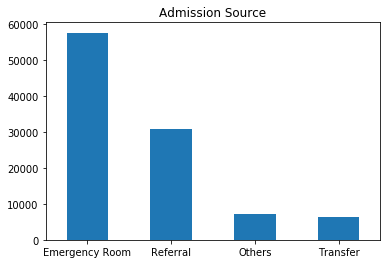

In [953]:
plt.title('Admission Source')
df['admission_source_id'].value_counts().plot(kind='bar')
plt.xticks(rotation=360)
plt.show()

#### discharge_disposition_id

In [954]:
discharge_mapping = pd.read_excel('discharge mapping.xlsx')
discharge_mapping

discharge_disposition_id  \
0                          1   
1                          2   
2                          3   
3                          4   
4                          5   
5                          6   
6                          7   
7                          8   
8                          9   
9                         10   
10                        11   
11                        12   
12                        13   
13                        14   
14                        15   
15                        16   
16                        17   
17                        18   
18                        19   
19                        20   
20                        21   
21                        22   
22                        23   
23                        24   
24                        25   
25                        26   
26                        30   
27                        27   
28                        28   
29                        29   

                                          description  
0                                  Discharged to home  
1   Discharged/transferred to another short term h...  
2                       Discharged/transferred to SNF  
3                       Discharged/transferred to ICF  
4   Discharged/transferred to another type of inpa...  
5   Discharged/transferred to home with home healt...  
6                                            Left AMA  
7   Discharged/transferred to home under care of H...  
8           Admitted as an inpatient to this hospital  
9   Neonate discharged to another hospital for neo...  
10                                            Expired  
11  Still patient or expected to return for outpat...  
12                                     Hospice / home  
13                         Hospice / medical facility  
14  Discharged/transferred within this institution...  
15  Discharged/transferred/referred another instit...  
16  Discharged/transferred/referred to this instit...  
17                                         Not Mapped  
18           Expired at home. Medicaid only, hospice.  
19  Expired in a medical facility. Medicaid only, ...  
20    Expired, place unknown. Medicaid only, hospice.  
21  Discharged/transferred to another rehab fac in...  
22  Discharged/transferred to a long term care hos...  
23  Discharged/transferred to a nursing facility c...  
24                                         Not Mapped  
25                                    Unknown/Invalid  
26  Discharged/transferred to another Type of Heal...  
27  Discharged/transferred to a federal health car...  
28  Discharged/transferred/referred to a psychiatr...  
29  Discharged/transferred to a Critical Access Ho...

In [955]:
for i in np.arange(1,30):
    replace_with = discharge_mapping[discharge_mapping['discharge_disposition_id']==i]['description'].values[0]
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(to_replace=i,value=replace_with)

In [956]:
df['discharge_disposition_id'].value_counts()

Discharged to home                                                                                           60234
Discharged/transferred to SNF                                                                                13954
Discharged/transferred to home with home health service                                                      12902
Not Mapped                                                                                                    4680
Discharged/transferred to another short term hospital                                                         2128
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1993
Expired                                                                                                       1642
Discharged/transferred to another type of inpatient care institution                                          1184
Discharged/transferred to ICF                                                   

In [957]:
replace = [
'Discharged/transferred to SNF',
'Discharged/transferred to another short term hospital',
'Discharged/transferred to another rehab fac including rehab units of a hospital .',
'Discharged/transferred to ICF',
'Admitted as an inpatient to this hospital',
'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',              
'Discharged/transferred within this institution to Medicare approved swing bed',
'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
'Neonate discharged to another hospital for neonatal aftercare',    
'Discharged/transferred to a federal health care facility.',
'Discharged/transferred/referred to this institution for outpatient services',
'Still patient or expected to return for outpatient services',
'Discharged/transferred/referred another institution for outpatient services',
'Discharged/transferred to another type of inpatient care institution',
'Discharged/transferred to a long term care hospital.',
'Expired at home. Medicaid only, hospice.',
'Expired in a medical facility. Medicaid only, hospice.',
'Hospice / medical facility',
'Hospice / home',
'Discharged/transferred to home with home health service',
'Discharged/transferred to home under care of Home IV provider'
]
replace_with = ['Discharged/Transferred'] *15 + ['Expired']*2 + ['Hospice']*4

df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(to_replace=replace,value=replace_with)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(to_replace=['Not Mapped','Left AMA'],value=['Others','Others'])
#df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(to_replace='Not Mapped',value=np.nan)
df['discharge_disposition_id'].value_counts()

Discharged to home        60234
Discharged/Transferred    20796
Hospice                   13781
Others                     5303
Expired                    1652
Name: discharge_disposition_id, dtype: int64

In [959]:
pd.crosstab(df['discharge_disposition_id'],df['readmitted<30']).sort_values('<30',ascending=False)

readmitted<30              <30     NO
discharge_disposition_id             
Discharged to home        5602  54632
Discharged/Transferred    3418  17378
Hospice                   1696  12085
Others                     641   4662
Expired                      0   1652

In [960]:
chisq_test(pd.crosstab(df['discharge_disposition_id'],df['readmitted<30']))

Feature Name:  discharge_disposition_id

---------------------

(1024.3415021227402, 1.8937860666349782e-220, 4, array([[ 6722.06373445, 53511.93626555],
       [ 2320.81610754, 18475.18389246],
       [  184.36181043,  1467.63818957],
       [ 1537.94800818, 12243.05199182],
       [  591.81033941,  4711.18966059]]))

---------------------

P-value:  1.8937860666349782e-220

==>> discharge_disposition_id  is a good feature for predicting readmission


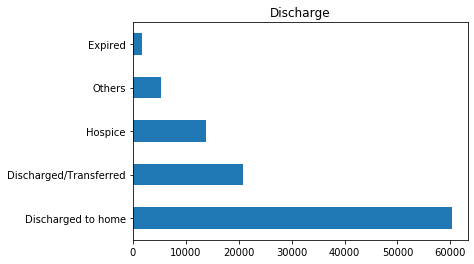

In [961]:
plt.title('Discharge')
df['discharge_disposition_id'].value_counts().plot(kind='barh')
plt.show()

#### Diagnosis 1,2 and 3

The International Classification of Diseases (ICD) is a globally used diagnostic tool for epidemiology, health management and clinical purposes. The ICD is maintained by the World Health Organization (WHO), which is the directing and coordinating authority for health within the United Nations System.[1] The ICD is originally designed as a health care classification system, providing a system of diagnostic codes for classifying diseases, including nuanced classifications of a wide variety of signs, symptoms, abnormal findings, complaints, social circumstances, and external causes of injury or disease. This system is designed to map health conditions to corresponding generic categories together with specific variations, assigning for these a designated code, up to six characters long. Thus, major categories are designed to include a set of similar diseases.

diag_1,diag_2 and diag_3 are represented as ICD-9 codes in the dataset

In [962]:
def ICD_mapper(diagnosis):
    """Maps the ICD-9 codes from diagnostic columns to its category"""
    
    mapped_diag_values = []
    for value in diagnosis:
        if value == '?':
            mapped_diag_values.append('None')
        
        else:
            
            if value.isnumeric():
                value_num = int(float(value))
                
                if (value_num >= 390 and value_num <=459) or (value_num == 785):
                    mapped_diag_values.append('Circulatory')
                    
                elif (value_num >= 520 and value_num <=579) or (value_num == 787):
                    mapped_diag_values.append('Digestive')
                    
                elif (value_num >= 580 and value_num <=629) or (value_num == 788):
                    mapped_diag_values.append('Genitourinary')
                    
                elif (value_num >=250 and  value_num < 251):
                    mapped_diag_values.append('Diabetes')
                    
                elif (value_num >=800 and  value_num <= 999):
                    mapped_diag_values.append('Injury')
                    
                elif (value_num >=710 and  value_num <= 739):
                    mapped_diag_values.append('Musculoskeletal')
                    
                elif (value_num >=140 and  value_num <= 239):
                    mapped_diag_values.append('Neoplasms')
                    
                elif (value_num >=460 and  value_num <= 519) or (value_num == 786):
                    mapped_diag_values.append('Injury')
                    
                else:
                    mapped_diag_values.append('Others')
                    
            else:
                    mapped_diag_values.append('Others')
                    
                
                    
    return mapped_diag_values

In [963]:
#creating a new df to handle diagnosis features
diagnosis_df = pd.DataFrame(df[['diag_1','diag_2','diag_3']])

In [964]:
#mapping icd-9 codes to its catgories
diagnosis_df['mapped_d1'] = ICD_mapper(diagnosis_df['diag_1'].replace(np.nan,'?'))
diagnosis_df['mapped_d2'] = ICD_mapper(diagnosis_df['diag_2'].replace(np.nan,'?'))
diagnosis_df['mapped_d3'] = ICD_mapper(diagnosis_df['diag_3'].replace(np.nan,'?'))

In [965]:
pd.crosstab(diagnosis_df['mapped_d1'],df['readmitted<30']).sort_values('<30',ascending=False)

readmitted<30     <30     NO
mapped_d1                   
Circulatory      3485  26952
Others           3207  23487
Injury           2257  19140
Digestive        1015   8460
Genitourinary     555   4562
Musculoskeletal   471   4486
Neoplasms         346   3087
Diabetes           16    219
None                5     16

In [966]:
pd.crosstab(diagnosis_df['mapped_d2'],df['readmitted<30']).sort_values('<30',ascending=False)

readmitted<30     <30     NO
mapped_d2                   
Others           3898  29378
Circulatory      3539  28342
Injury           1424  11899
Genitourinary     985   7391
Digestive         479   3691
Diabetes          446   5625
Neoplasms         380   2167
Musculoskeletal   177   1587
None               29    329

In [967]:
pd.crosstab(diagnosis_df['mapped_d3'],df['readmitted<30']).sort_values('<30',ascending=False)

readmitted<30     <30     NO
mapped_d3                   
Others           4058  30739
Circulatory      3275  27031
Injury           1112   8192
Diabetes          984  10571
Genitourinary     899   5781
Digestive         470   3460
Neoplasms         264   1592
Musculoskeletal   204   1711
None               91   1332

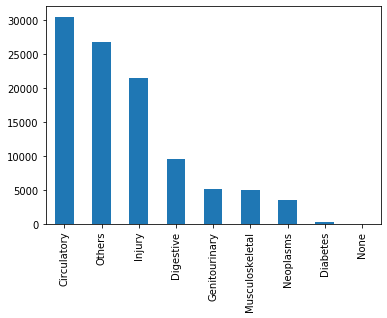

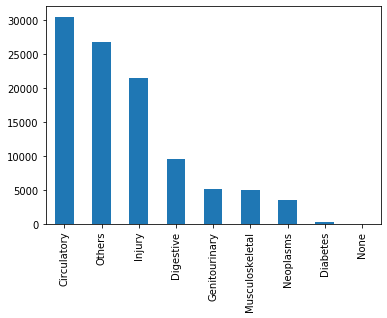

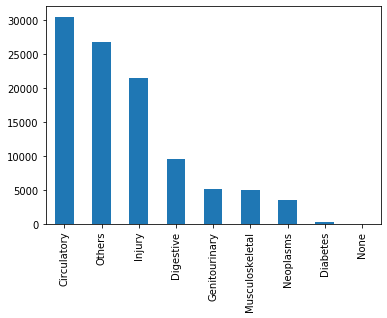

In [968]:
diagnosis_df['mapped_d1'].value_counts().plot(kind='bar')
plt.show()
diagnosis_df['mapped_d1'].value_counts().plot(kind='bar')
plt.show()
diagnosis_df['mapped_d1'].value_counts().plot(kind='bar')
plt.show()

In [969]:
primary_diag = pd.DataFrame(pd.crosstab(diagnosis_df['mapped_d1'],df['readmitted<30']).sort_values('<30',ascending=False))

In [970]:
primary_diag['Readmitted %'] = (primary_diag['<30']/(primary_diag['<30']+primary_diag['NO']))*100

In [973]:
primary_diag.head(7).sort_values('Readmitted %',ascending=False)

readmitted<30     <30     NO  Readmitted %
mapped_d1                                 
Others           3207  23487     12.013936
Circulatory      3485  26952     11.449880
Genitourinary     555   4562     10.846199
Digestive        1015   8460     10.712401
Injury           2257  19140     10.548208
Neoplasms         346   3087     10.078648
Musculoskeletal   471   4486      9.501715

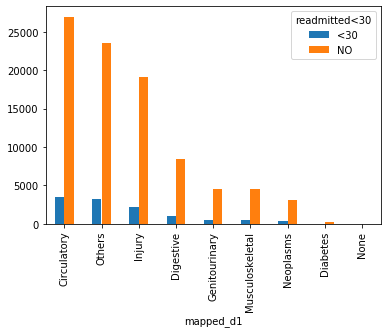

In [974]:
pd.crosstab(diagnosis_df['mapped_d1'],df['readmitted<30']).sort_values('<30',ascending=False).plot(kind='bar')
plt.show()

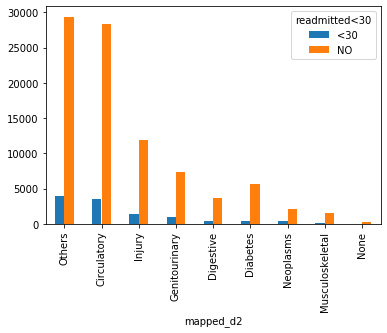

In [975]:
pd.crosstab(diagnosis_df['mapped_d2'],df['readmitted<30']).sort_values('<30',ascending=False).plot(kind='bar')
plt.show()

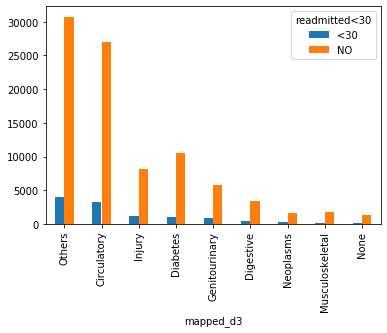

In [976]:
pd.crosstab(diagnosis_df['mapped_d3'],df['readmitted<30']).sort_values('<30',ascending=False).plot(kind='bar')
plt.show()

In [977]:
chisq_test(pd.crosstab(diagnosis_df['mapped_d1'],df['readmitted<30']))

Feature Name:  mapped_d1

---------------------

(58.388873740028004, 9.64061819919478e-10, 8, array([[3.39674360e+03, 2.70402564e+04],
       [2.62258023e+01, 2.08774198e+02],
       [1.05740203e+03, 8.41759797e+03],
       [5.71052896e+02, 4.54594710e+03],
       [2.38788720e+03, 1.90091128e+04],
       [5.53197030e+02, 4.40380297e+03],
       [3.83119912e+02, 3.04988009e+03],
       [2.34358234e+00, 1.86564177e+01],
       [2.97902795e+03, 2.37149721e+04]]))

---------------------

P-value:  9.64061819919478e-10

==>> mapped_d1  is a good feature for predicting readmission


In [978]:
chisq_test(pd.crosstab(diagnosis_df['mapped_d2'],df['readmitted<30']))

Feature Name:  mapped_d2

---------------------

(147.89913586872743, 5.376514147542792e-28, 8, array([[ 3557.89278344, 28323.10721656],
       [  677.51849341,  5393.48150659],
       [  465.36849242,  3704.63150758],
       [  934.75455457,  7441.24544543],
       [ 1486.83559342, 11836.16440658],
       [  196.86091622,  1567.13908378],
       [  284.2430576 ,  2262.7569424 ],
       [   39.95249887,   318.04750113],
       [ 3713.57361005, 29562.42638995]]))

---------------------

P-value:  5.376514147542792e-28

==>> mapped_d2  is a good feature for predicting readmission


In [979]:
chisq_test(pd.crosstab(diagnosis_df['mapped_d3'],df['readmitted<30']))

Feature Name:  mapped_d3

---------------------

(188.81188587028672, 1.447901682661951e-36, 8, array([[ 3382.12410825, 26923.87589175],
       [ 1289.52828057, 10265.47171943],
       [  438.5846943 ,  3491.4153057 ],
       [  745.48238115,  5934.51761885],
       [ 1038.31857398,  8265.68142602],
       [  213.71238921,  1701.28761079],
       [  207.12803883,  1648.87196117],
       [  158.80560305,  1264.19439695],
       [ 3883.31593066, 30913.68406934]]))

---------------------

P-value:  1.447901682661951e-36

==>> mapped_d3  is a good feature for predicting readmission


#### Gender

In [980]:
df['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [981]:
#replacing null values(Unknown/Invalid) by mode imputation
df['gender'] = df['gender'].replace('Unknown/Invalid','Female')

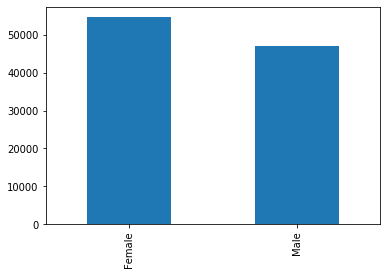

In [982]:
df['gender'].value_counts().plot(kind='bar')

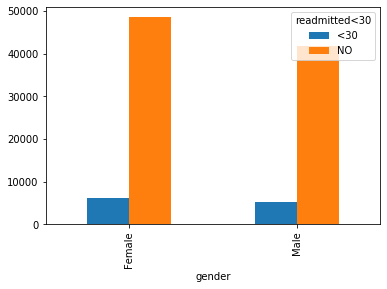

In [983]:
pd.crosstab(df['gender'],df['readmitted<30']).plot(kind='bar')

In [984]:
chisq_test(pd.crosstab(df['gender'],df['readmitted<30']))

Feature Name:  gender

---------------------

(0.8362832164001014, 0.3604619409578229, 1, array([[ 6105.7015801, 48605.2984199],
       [ 5251.2984199, 41803.7015801]]))

---------------------

P-value:  0.3604619409578229

==>> gender  is NOT a good feature for predicting readmission


#### Race

In [985]:
df['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [986]:
df['race'].isna().sum()

2273

In [987]:
df['race'] = df['race'].fillna(df['race'].mode()[0])

In [988]:
df['race'].value_counts()

Caucasian          78372
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [989]:
pd.crosstab(df['race'],df['readmitted<30'])

readmitted<30     <30     NO
race                        
AfricanAmerican  2155  17055
Asian              65    576
Caucasian        8780  69592
Hispanic          212   1825
Other             145   1361

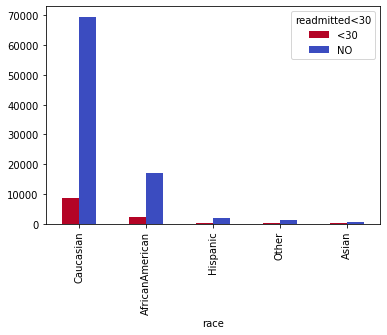

In [992]:
pd.crosstab(df['race'],df['readmitted<30']).sort_values('<30',ascending=False).plot(kind='bar',colormap=plt.cm.coolwarm_r)

In [993]:
chisq_test(pd.crosstab(df['race'],df['readmitted<30']))

Feature Name:  race

---------------------

(5.611503365617651, 0.2301007184341754, 4, array([[ 2143.8198416 , 17066.1801584 ],
       [   71.53506083,   569.46493917],
       [ 8746.24927775, 69625.75072225],
       [  227.32748659,  1809.67251341],
       [  168.06833324,  1337.93166676]]))

---------------------

P-value:  0.2301007184341754

==>> race  is NOT a good feature for predicting readmission


#### Age

In [994]:
df['age'].value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

In [995]:
pd.crosstab(df['age'],df['readmitted<30']).sort_values('<30',ascending=False)

readmitted<30   <30     NO
age                       
[70-80)        3069  22999
[60-70)        2502  19981
[80-90)        2078  15119
[50-60)        1668  15588
[40-50)        1027   8658
[30-40)         424   3351
[90-100)        310   2483
[20-30)         236   1421
[10-20)          40    651
[0-10)            3    158

In [996]:
df['age'] = df['age'].replace(['[0-10)','[10-20)','[20-30)','[80-90)','[90-100)'],['[0-30)','[0-30)','[0-30)','[80-100)','[80-100)'])

In [997]:
pd.crosstab(df['age'],df['readmitted<30']).sort_values('<30',ascending=False)

readmitted<30   <30     NO
age                       
[70-80)        3069  22999
[60-70)        2502  19981
[80-100)       2388  17602
[50-60)        1668  15588
[40-50)        1027   8658
[30-40)         424   3351
[0-30)          279   2230

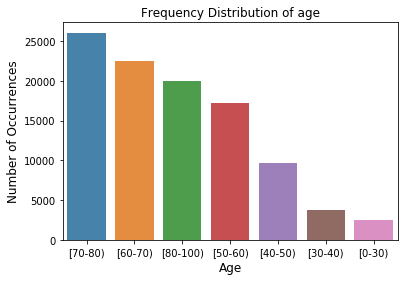

In [998]:
age_count = df['age'].value_counts()
#sns.set(style="darkgrid")
sns.barplot(age_count.index, age_count.values, alpha=0.9)
plt.title('Frequency Distribution of age')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.show()

In [999]:
chisq_test((pd.crosstab(df['age'],df['readmitted<30'])))

Feature Name:  age

---------------------

(64.2407463014594, 6.163896785186736e-12, 6, array([[  280.00228957,  2228.99771043],
       [  421.28682468,  3353.71317532],
       [ 1080.83785351,  8604.16214649],
       [ 1925.7550852 , 15330.2449148 ],
       [ 2509.08388853, 19973.91611147],
       [ 2909.16687302, 23158.83312698],
       [ 2230.8671855 , 17759.1328145 ]]))

---------------------

P-value:  6.163896785186736e-12

==>> age  is a good feature for predicting readmission


###### age derived

In [1000]:
from scipy.stats import ttest_ind

In [1001]:
df['age'].unique()

array(['[0-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)',
       '[80-100)'], dtype=object)

In [1002]:
df['age_derived'] = df['age'].replace(['[0-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-100)'],
                                     [15,35,45,55,65,75,90])
#for i in range(0,10):
   # df['age_derived'] = df['age_derived'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)
df['age_derived'].value_counts()

75    26068
65    22483
90    19990
55    17256
45     9685
35     3775
15     2509
Name: age_derived, dtype: int64

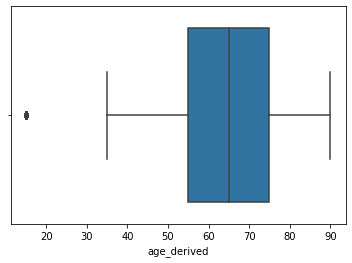

In [1003]:
sns.boxplot(df['age_derived'])

In [1004]:
ttest_ind(df[df['readmitted<30']=='NO']['age_derived'],df[df['readmitted<30']=='<30']['age_derived'])

Ttest_indResult(statistic=-5.294291904315122, pvalue=1.1972549626470062e-07)

#### max_glu_serum 

In [1005]:
df['max_glu_serum'].value_counts()

None    96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

In [1013]:
pd.crosstab(df['max_glu_serum'],df['readmitted<30']).sort_values('<30',ascending=False)

readmitted<30    <30     NO
max_glu_serum              
None           10696  85724
Norm             295   2302
>200             185   1300
>300             181   1083

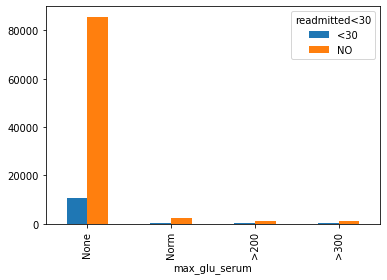

In [1008]:
pd.crosstab(df['max_glu_serum'],df['readmitted<30']).sort_values('<30',ascending=False).plot(kind='bar')

In [1009]:
chisq_test(pd.crosstab(df['max_glu_serum'],df['readmitted<30']))

Feature Name:  max_glu_serum

---------------------

(15.789606137609265, 0.0012523517486861331, 3, array([[  165.7247509 ,  1319.2752491 ],
       [  141.06133679,  1122.93866321],
       [10760.39089676, 85659.60910324],
       [  289.82301555,  2307.17698445]]))

---------------------

P-value:  0.0012523517486861331

==>> max_glu_serum  is a good feature for predicting readmission


#### A1Cresult

In [1010]:
df['A1Cresult'].value_counts()

None    84748
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

In [1012]:
pd.crosstab(df['A1Cresult'],df['readmitted<30']).sort_values('<30',ascending=False)

readmitted<30   <30     NO
A1Cresult                 
None           9681  75067
>8              811   7405
Norm            482   4508
>7              383   3429

In [762]:
#pd.crosstab(df['A1Cresult'],df['readmitted<30']).plot(kind='bar',colormap=plt.cm.coolwarm_r)

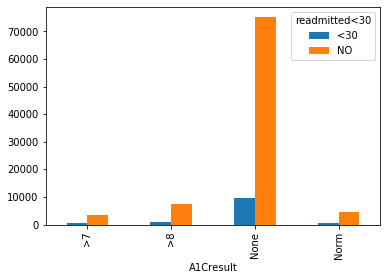

In [763]:
pd.crosstab(df['A1Cresult'],df['readmitted<30']).plot(kind='bar')

In [1014]:
chisq_test(pd.crosstab(df['A1Cresult'],df['readmitted<30']))

Feature Name:  A1Cresult

---------------------

(35.789867640708316, 8.29491004183731e-08, 3, array([[  425.41599355,  3386.58400645],
       [  916.89868915,  7299.10131085],
       [ 9457.80551461, 75290.19448539],
       [  556.87980268,  4433.12019732]]))

---------------------

P-value:  8.29491004183731e-08

==>> A1Cresult  is a good feature for predicting readmission


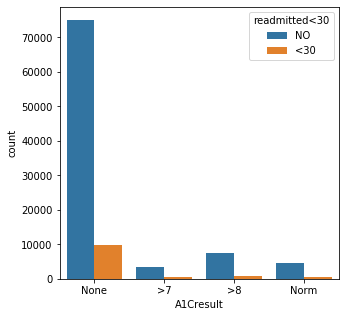

In [1015]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x = df['A1Cresult'], hue = df['readmitted<30'])

#### Medicines

In [1016]:
cols=['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide','citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

In [1017]:
for col in cols:
    print('Medicine Name: ',col)
    print(df[col].value_counts())
    print('\n----------------------\n')

Medicine Name:  metformin
No        81778
Steady    18346
Up         1067
Down        575
Name: metformin, dtype: int64

----------------------

Medicine Name:  repaglinide
No        100227
Steady      1384
Up           110
Down          45
Name: repaglinide, dtype: int64

----------------------

Medicine Name:  nateglinide
No        101063
Steady       668
Up            24
Down          11
Name: nateglinide, dtype: int64

----------------------

Medicine Name:  chlorpropamide
No        101680
Steady        79
Up             6
Down           1
Name: chlorpropamide, dtype: int64

----------------------

Medicine Name:  glimepiride
No        96575
Steady     4670
Up          327
Down        194
Name: glimepiride, dtype: int64

----------------------

Medicine Name:  acetohexamide
No        101765
Steady         1
Name: acetohexamide, dtype: int64

----------------------

Medicine Name:  glipizide
No        89080
Steady    11356
Up          770
Down        560
Name: glipizide, dtype: int6

In [1018]:
med=pd.DataFrame(index=cols)
med['No']=0
med['Steady']=0
med['Up']=0
med['Down']=0
med['P_value']=0
med.index

Index(['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'],
      dtype='object')

In [1019]:
import scipy.stats as stats

In [1020]:
for i in med.index:
    count=df[i].value_counts()
    for col in count.index:
        med.loc[i,col]=round((count[col]/df.shape[0])*100,2)
    med.loc[i,'P_value']=stats.chi2_contingency(pd.crosstab(df[i],df['readmitted<30']))[1]

In [1021]:
med

No  Steady     Up   Down       P_value
metformin                  80.36   18.03   1.05   0.57  1.085303e-12
repaglinide                98.49    1.36   0.11   0.04  7.286841e-03
nateglinide                99.31    0.66   0.02   0.01  7.028431e-01
chlorpropamide             99.92    0.08   0.01   0.00  4.333180e-01
glimepiride                94.90    4.59   0.32   0.19  7.348629e-02
acetohexamide             100.00    0.00   0.00   0.00  2.173806e-01
glipizide                  87.53   11.16   0.76   0.55  9.272622e-03
glyburide                  89.53    9.11   0.80   0.55  2.014449e-01
tolbutamide                99.98    0.02   0.00   0.00  4.798639e-01
pioglitazone               92.80    6.85   0.23   0.12  9.385151e-02
rosiglitazone              93.75    5.99   0.17   0.09  1.420400e-01
acarbose                   99.70    0.29   0.01   0.00  2.190269e-01
miglitol                   99.96    0.03   0.00   0.00  1.618968e-01
troglitazone              100.00    0.00   0.00   0.00  7.619511e-01
tolazamide                 99.96    0.04   0.00   0.00  7.655096e-01
examide                   100.00    0.00   0.00   0.00  1.000000e+00
citoglipton               100.00    0.00   0.00   0.00  1.000000e+00
insulin                    46.56   30.31  11.12  12.01  3.981889e-41
glyburide-metformin        99.31    0.68   0.01   0.01  7.555789e-01
glipizide-metformin        99.99    0.01   0.00   0.00  9.654230e-01
glimepiride-pioglitazone  100.00    0.00   0.00   0.00  2.173806e-01
metformin-rosiglitazone   100.00    0.00   0.00   0.00  5.341936e-01
metformin-pioglitazone    100.00    0.00   0.00   0.00  2.173806e-01

In [1022]:
med[med['No']<99]

No  Steady     Up   Down       P_value
metformin      80.36   18.03   1.05   0.57  1.085303e-12
repaglinide    98.49    1.36   0.11   0.04  7.286841e-03
glimepiride    94.90    4.59   0.32   0.19  7.348629e-02
glipizide      87.53   11.16   0.76   0.55  9.272622e-03
glyburide      89.53    9.11   0.80   0.55  2.014449e-01
pioglitazone   92.80    6.85   0.23   0.12  9.385151e-02
rosiglitazone  93.75    5.99   0.17   0.09  1.420400e-01
insulin        46.56   30.31  11.12  12.01  3.981889e-41

In [1026]:
#getting statsistically significant columns
final_med_cols=med[med['P_value']<.05].index
final_med_cols

Index(['metformin', 'repaglinide', 'glipizide', 'insulin'], dtype='object')

In [1027]:
meds_to_del = list(set(cols) - set(final_med_cols))

In [1028]:
#Insignificant medicines:
meds_to_del

['metformin-rosiglitazone',
 'tolazamide',
 'glyburide',
 'tolbutamide',
 'glipizide-metformin',
 'acetohexamide',
 'examide',
 'citoglipton',
 'chlorpropamide',
 'acarbose',
 'miglitol',
 'troglitazone',
 'glyburide-metformin',
 'glimepiride-pioglitazone',
 'metformin-pioglitazone',
 'pioglitazone',
 'glimepiride',
 'nateglinide',
 'rosiglitazone']

In [1029]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'readmitted<30', 'age_derived'],
      dtype='object')

In [1030]:
#dropping insignificant medicines(columns) from the Dataframe
df.drop(meds_to_del,axis=1,inplace=True)

In [1031]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'glipizide', 'insulin', 'change',
       'diabetesMed', 'readmitted', 'readmitted<30', 'age_derived'],
      dtype='object')

#### Deriving Features from medicine columns

In [1032]:
#Function to count the number of variables in each row.
def count(df_count):    
    typ=['No','Steady','Down','Up']
    cols=df_count.columns
    for i in typ: 
        for col in cols:
            cnt='count_'+i
            colname = str(col) + 'temp'
            df_count[colname] = df_count[col].apply(lambda x: 1 if (x == i) else 0)
        df_count[cnt] = 0
        for col in cols:
            colname = str(col) + 'temp'
            df_count[cnt] = df_count[cnt] + df_count[colname]
            del df_count[colname]
    return (df_count)

In [1033]:
df_final=df[final_med_cols]
df_final.head()

metformin repaglinide glipizide insulin
0        No          No        No      No
1        No          No        No      Up
2        No          No    Steady      No
3        No          No        No      Up
4        No          No    Steady  Steady

In [1034]:
df_final=count(df_final)

D:\DSE\softwares\anacondapython\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
D:\DSE\softwares\anacondapython\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\DSE\softwares\anacondapython\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [1035]:
df_final.head()

metformin repaglinide glipizide insulin  count_No  count_Steady  count_Down  \
0        No          No        No      No         4             0           0   
1        No          No        No      Up         3             0           0   
2        No          No    Steady      No         3             1           0   
3        No          No        No      Up         3             0           0   
4        No          No    Steady  Steady         2             2           0   

   count_Up  
0         0  
1         1  
2         0  
3         1  
4         0

In [1036]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'glipizide', 'insulin', 'change',
       'diabetesMed', 'readmitted', 'readmitted<30', 'age_derived'],
      dtype='object')

In [1037]:
df = pd.concat([df,df_final[['count_No','count_Steady','count_Down','count_Up']]],axis=1)

In [1038]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'glipizide', 'insulin', 'change',
       'diabetesMed', 'readmitted', 'readmitted<30', 'age_derived', 'count_No',
       'count_Steady', 'count_Down', 'count_Up'],
      dtype='object')

Statistical test for derived features

In [1039]:
med_data=pd.DataFrame(index=['count_No','count_Steady','count_Up','count_Down'])
med_data['P_value']=0

In [1040]:
df_count_No=df_final[df['readmitted<30']=='NO']
df_count_30=df_final[df['readmitted<30']=='<30']

In [1041]:
df_count_30.shape[0] + df_count_No.shape[0]

101766

In [1042]:
from scipy.stats import ttest_ind

In [1043]:
for i in med_data.index:
    med_data.loc[i,'P_value']=ttest_ind(df_count_No[i],df_count_30[i])[1]
    
med_data

P_value
count_No      2.106032e-05
count_Steady  4.384197e-04
count_Up      1.416969e-08
count_Down    1.214462e-25

Derived Features: 'count_No','count_Steady','count_Up','count_Down' are statistically significant

#### Numerical Features

In [1044]:
from sklearn.preprocessing import PowerTransformer,StandardScaler

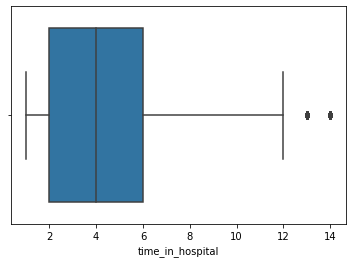

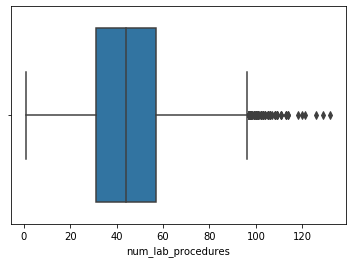

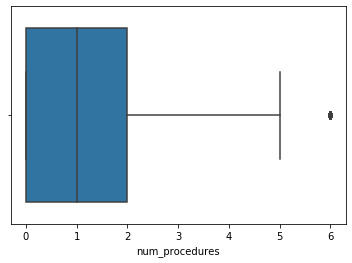

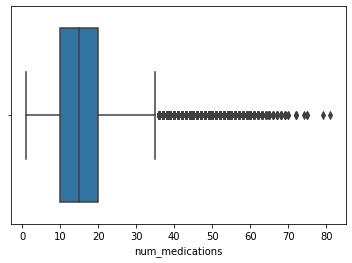

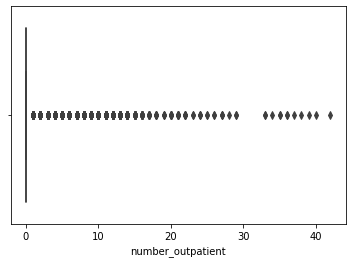

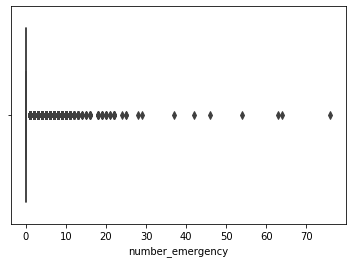

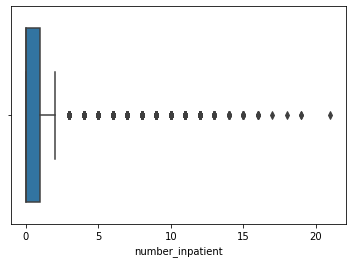

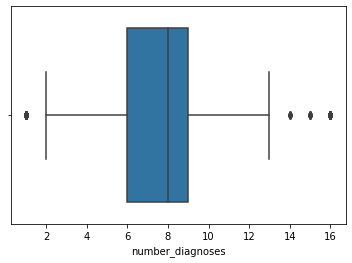

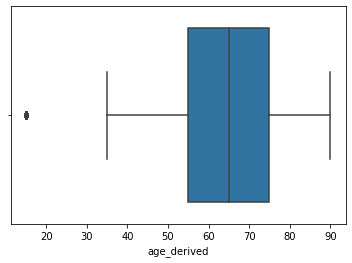

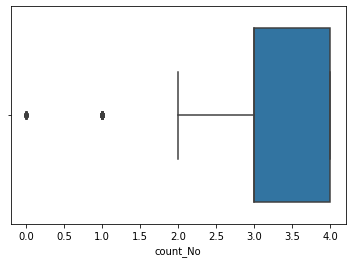

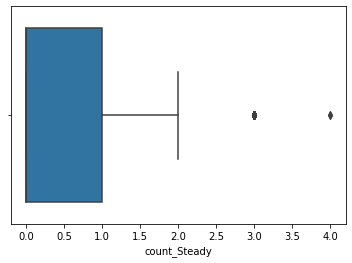

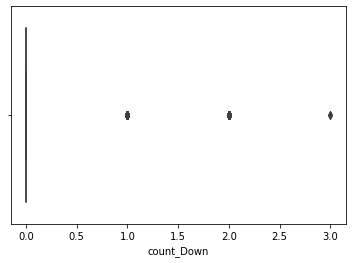

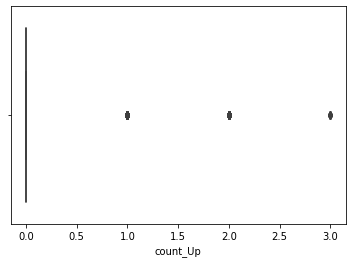

In [1045]:
for col in df.select_dtypes(exclude = 'object'):
    sns.boxplot(df[col])
    plt.show()

time_in_hospital


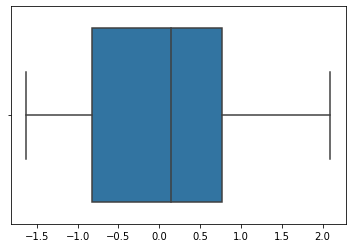

**********************

num_lab_procedures


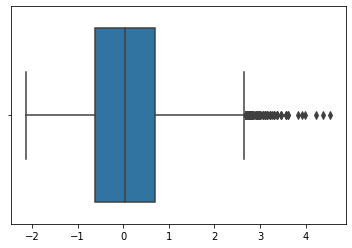

**********************

num_procedures


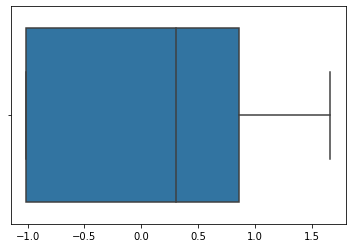

**********************

num_medications


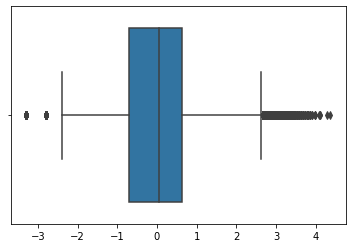

**********************

number_outpatient


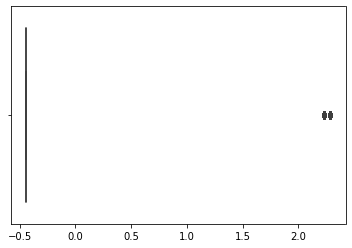

**********************

number_emergency


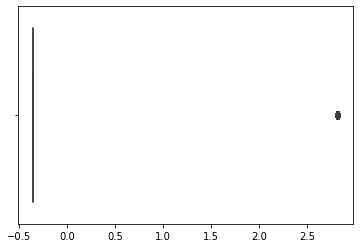

**********************

number_inpatient


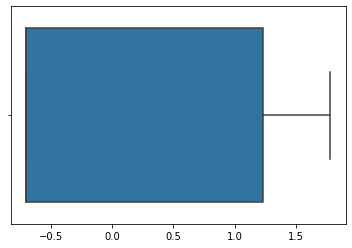

**********************

number_diagnoses


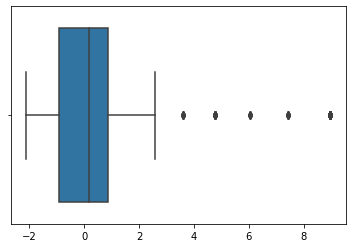

**********************

age_derived


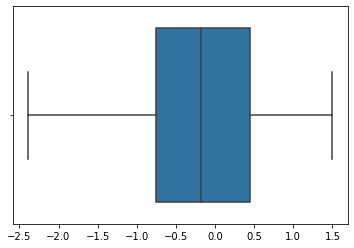

**********************

count_No


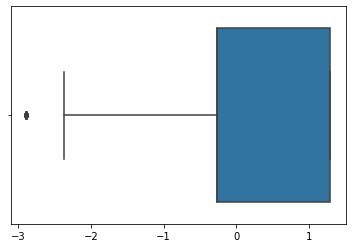

**********************

count_Steady


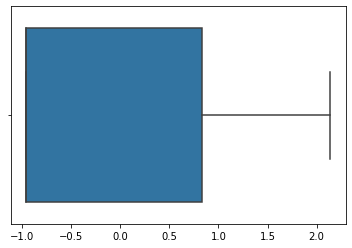

**********************

count_Down


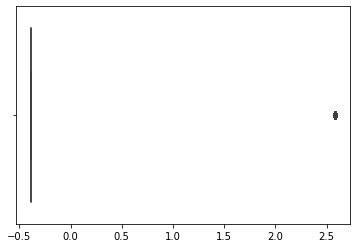

**********************

count_Up


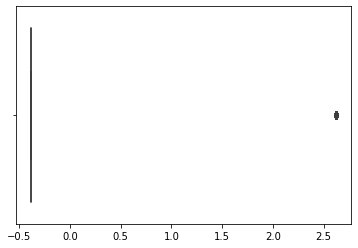

**********************



In [1046]:
pt = PowerTransformer()
for col in df.select_dtypes(exclude = 'object'):
    print(col)
    sns.boxplot(pt.fit_transform(df[[col]]))
    plt.show()
    print('**********************\n')

#### time_in_hospital

In [1047]:
df_30 = df[df['readmitted<30'] == '<30']
df_no = df[df['readmitted<30'] == 'NO']

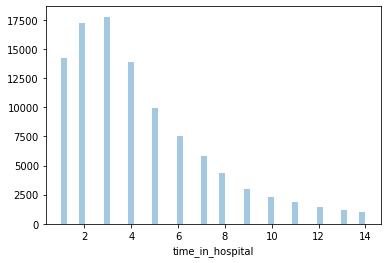

In [1048]:
sns.distplot(df.time_in_hospital,kde=False)
plt.show()

In [1049]:
df_pt = df[['time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient',
       'number_diagnoses','count_No','count_Steady','count_Up','count_Down','age_derived']]

In [1050]:
df_pt.skew()

time_in_hospital       1.133999
num_lab_procedures    -0.236544
num_procedures         1.316415
num_medications        1.326672
number_outpatient      8.832959
number_emergency      22.855582
number_inpatient       3.614139
number_diagnoses      -0.876746
count_No              -0.527701
count_Steady           0.882664
count_Up               2.428197
count_Down             2.287173
age_derived           -0.598535
dtype: float64

In [1051]:
pt=PowerTransformer()

In [1052]:
df_pt = pd.DataFrame(pt.fit_transform(df_pt),columns=df_pt.columns)

In [1053]:
df_pt.head()

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0         -1.632460           -0.108475       -1.014380        -3.304858   
1         -0.271144            0.808522       -1.014380         0.408817   
2         -0.825587           -1.629615        1.546392        -0.237590   
3         -0.825587            0.044197        0.307973         0.167145   
4         -1.632460            0.400694       -1.014380        -1.082723   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  \
0          -0.443669         -0.354883         -0.705640         -2.125874   
1          -0.443669         -0.354883         -0.705640          0.865090   
2           2.278833         -0.354883          1.229785         -0.909684   
3          -0.443669         -0.354883         -0.705640         -0.417314   
4          -0.443669         -0.354883         -0.705640         -1.310201   

   count_No  count_Steady  count_Up  count_Down  age_derived  
0  1.289137     -0.964053 -0.382050   -0.386999    -2.390913  
1 -0.273195     -0.964053  2.617432   -0.386999    -2.390913  
2 -0.273195      0.835716 -0.382050   -0.386999    -2.390913  
3 -0.273195     -0.964053  2.617432   -0.386999    -1.716517  
4 -1.491824      1.525004 -0.382050   -0.386999    -1.267255

In [1054]:
df_pt.skew()

time_in_hospital      0.012906
num_lab_procedures   -0.226734
num_procedures        0.207261
num_medications       0.018905
number_outpatient     1.810634
number_emergency      2.462986
number_inpatient      0.740986
number_diagnoses     -0.137440
count_No             -0.087107
count_Steady          0.179256
count_Up              2.235445
count_Down            2.197018
age_derived          -0.106769
dtype: float64

In [1055]:
df_pt['readmitted<30'] = df['readmitted<30']

In [1059]:
num_cols_to_del = []
for col in ['time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient',
       'number_diagnoses','count_No','count_Steady','count_Up','count_Down','age_derived']:
    
    print(col,'\n--------')
    print(ttest_ind(df_pt[df_pt['readmitted<30'] == 'NO'][col],df_pt[df_pt['readmitted<30'] == '<30'][col]))
    print('\n***************\n')
    if ttest_ind(df_pt[df_pt['readmitted<30'] == 'NO'][col],df_pt[df_pt['readmitted<30'] == '<30'][col])[1] >0.05:
        num_cols_to_del.append(col)

time_in_hospital 
--------
Ttest_indResult(statistic=-16.133492233961917, pvalue=1.7543307105959315e-58)

***************

num_lab_procedures 
--------
Ttest_indResult(statistic=-6.493292218441432, pvalue=8.436532643105866e-11)

***************

num_procedures 
--------
Ttest_indResult(statistic=1.639388286190851, pvalue=0.10113551069087685)

***************

num_medications 
--------
Ttest_indResult(statistic=-14.06906426098672, pvalue=6.484281401015588e-45)

***************

number_outpatient 
--------
Ttest_indResult(statistic=-11.080668466194178, pvalue=1.616725782199147e-28)

***************

number_emergency 
--------
Ttest_indResult(statistic=-19.615849288907764, pvalue=1.6305968132333886e-85)

***************

number_inpatient 
--------
Ttest_indResult(statistic=-42.319817861984625, pvalue=0.0)

***************

number_diagnoses 
--------
Ttest_indResult(statistic=-15.167569817498716, pvalue=6.6096933130027804e-52)

***************

count_No 
--------
Ttest_indResult(statistic=

In [1060]:
num_cols_to_del

['num_procedures']

In [1061]:
for col in df.select_dtypes(exclude = 'object'):
    df[col] = df_pt[col]

In [1062]:
df.drop(num_cols_to_del,axis=1,inplace=True)

#### num_lab_procedures

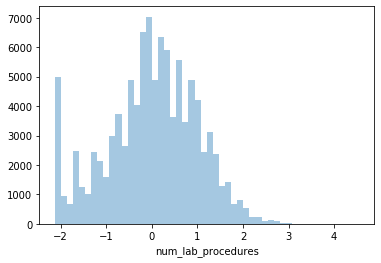

In [1063]:
sns.distplot(df_pt.num_lab_procedures,kde=False)
plt.show()

In [1064]:
df.num_lab_procedures.std()

1.0000049132685007

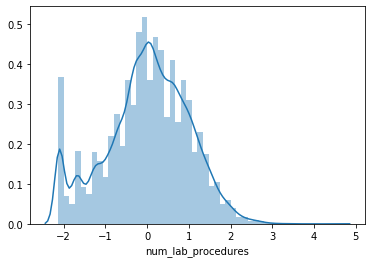

In [1065]:
sns.distplot(df_pt.num_lab_procedures,kde=True)
plt.show()

#### num_procedures

#### num_medications

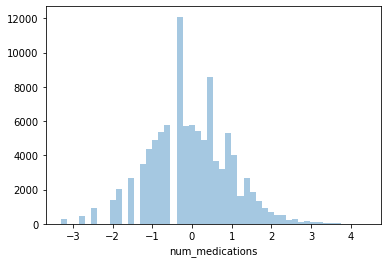

In [1067]:
sns.distplot(df.num_medications,kde=False)
plt.show()

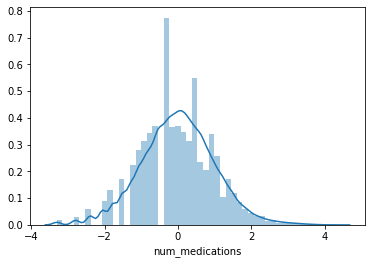

In [1068]:
sns.distplot(df_pt.num_medications,kde=True)
plt.show()

#### number_outpatient

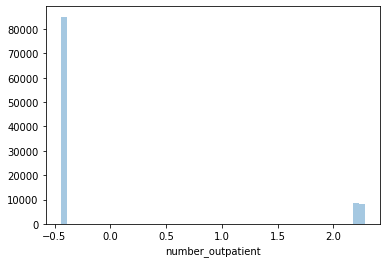

In [1069]:
sns.distplot(df.number_outpatient,kde=False)
plt.show()

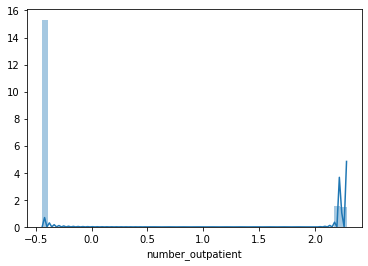

In [1070]:
sns.distplot(df_pt.number_outpatient,kde=True)
plt.show()

#### number_emergency

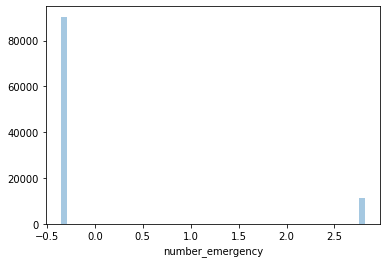

In [1071]:
sns.distplot(df.number_emergency,kde=False)
plt.show()

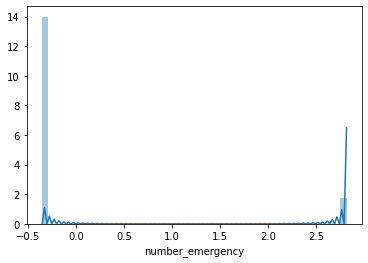

In [1072]:
sns.distplot(df_pt.number_emergency,kde=True)
plt.show()

#### number_inpatient

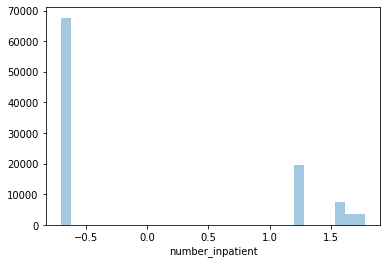

In [1073]:
sns.distplot(df.number_inpatient,kde=False)
plt.show()

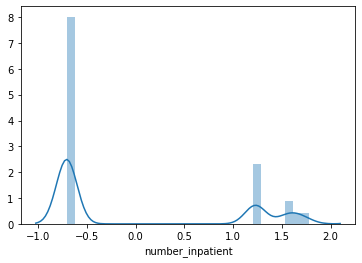

In [1074]:
sns.distplot(df_pt.number_inpatient,kde=True)
plt.show()

#### Number of Diagnosis (number_diagnoses)

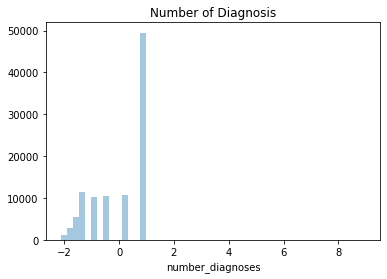

In [1075]:
plt.title('Number of Diagnosis')
sns.distplot(df['number_diagnoses'],kde=False)
plt.show()

In [1076]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'glipizide', 'insulin', 'change', 'diabetesMed',
       'readmitted', 'readmitted<30', 'age_derived', 'count_No',
       'count_Steady', 'count_Down', 'count_Up'],
      dtype='object')

#### VIF

In [1077]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [1078]:
df_pt.drop('readmitted<30',axis=1,inplace = True)

In [1079]:
calc_vif(df_pt)

variables        VIF
0     time_in_hospital   1.408037
1   num_lab_procedures   1.162010
2       num_procedures   1.203177
3      num_medications   1.650611
4    number_outpatient   1.063425
5     number_emergency   1.083333
6     number_inpatient   1.089483
7     number_diagnoses   1.185039
8             count_No  21.067882
9         count_Steady  19.622648
10            count_Up   6.028523
11          count_Down   6.126038
12         age_derived   1.079878

In [1080]:
calc_vif(df_pt.drop('count_No',axis=1))

variables       VIF
0     time_in_hospital  1.408016
1   num_lab_procedures  1.161855
2       num_procedures  1.201904
3      num_medications  1.645086
4    number_outpatient  1.063422
5     number_emergency  1.083286
6     number_inpatient  1.089353
7     number_diagnoses  1.185035
8         count_Steady  1.133751
9             count_Up  1.127403
10          count_Down  1.132302
11         age_derived  1.079432

In [1081]:
df.drop('count_No',axis=1,inplace = True)

In [1082]:
df['diag_1'] = diagnosis_df['mapped_d1']
df['diag_2'] = diagnosis_df['mapped_d2']
df['diag_3'] = diagnosis_df['mapped_d3']

In [1083]:
df['readmitted'] = df['readmitted<30']
df.drop(['readmitted<30'],axis=1,inplace=True)

In [1084]:
df.head().T

0                   1                   2  \
race                      Caucasian           Caucasian     AfricanAmerican   
gender                       Female              Female              Female   
age                          [0-30)              [0-30)              [0-30)   
admission_type_id            Others           Emergency           Emergency   
discharge_disposition_id     Others  Discharged to home  Discharged to home   
admission_source_id        Referral      Emergency Room      Emergency Room   
time_in_hospital           -1.63246           -0.271144           -0.825587   
num_lab_procedures        -0.108475            0.808522            -1.62962   
num_medications            -3.30486            0.408817            -0.23759   
number_outpatient         -0.443669           -0.443669             2.27883   
number_emergency          -0.354883           -0.354883           -0.354883   
number_inpatient           -0.70564            -0.70564             1.22979   
diag_1                       Others              Others              Others   
diag_2                         None              Others            Diabetes   
diag_3                         None              Others              Others   
number_diagnoses           -2.12587             0.86509           -0.909684   
max_glu_serum                  None                None                None   
A1Cresult                      None                None                None   
metformin                        No                  No                  No   
repaglinide                      No                  No                  No   
glipizide                        No                  No              Steady   
insulin                          No                  Up                  No   
change                           No                  Ch                  No   
diabetesMed                      No                 Yes                 Yes   
readmitted                       NO                  NO                  NO   
age_derived                -2.39091            -2.39091            -2.39091   
count_Steady              -0.964053           -0.964053            0.835716   
count_Down                -0.386999           -0.386999           -0.386999   
count_Up                   -0.38205             2.61743            -0.38205   

                                           3                   4  
race                               Caucasian           Caucasian  
gender                                  Male                Male  
age                                  [30-40)             [40-50)  
admission_type_id                  Emergency           Emergency  
discharge_disposition_id  Discharged to home  Discharged to home  
admission_source_id           Emergency Room      Emergency Room  
time_in_hospital                   -0.825587            -1.63246  
num_lab_procedures                 0.0441968            0.400694  
num_medications                     0.167145            -1.08272  
number_outpatient                  -0.443669           -0.443669  
number_emergency                   -0.354883           -0.354883  
number_inpatient                    -0.70564            -0.70564  
diag_1                                Others           Neoplasms  
diag_2                                Others           Neoplasms  
diag_3                           Circulatory            Diabetes  
number_diagnoses                   -0.417314             -1.3102  
max_glu_serum                           None                None  
A1Cresult                               None                None  
metformin                                 No                  No  
repaglinide                               No                  No  
glipizide                                 No              Steady  
insulin                                   Up              Steady  
change                                    Ch                  Ch  
diabetesMed                              Yes           

In [1085]:
categ_cols = df.select_dtypes(include = 'object').columns.values
for col in categ_cols:
    print('Column: ',col)
    print(df[col].value_counts())
    tot = df[col].value_counts().sum()
    print('Total: ',tot)
    print('Missing value %: ',((101766-tot)/101766)*100)
    print('----------------------------\n')

Column:  race
Caucasian          78372
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64
Total:  101766
Missing value %:  0.0
----------------------------

Column:  gender
Female    54711
Male      47055
Name: gender, dtype: int64
Total:  101766
Missing value %:  0.0
----------------------------

Column:  age
[70-80)     26068
[60-70)     22483
[80-100)    19990
[50-60)     17256
[40-50)      9685
[30-40)      3775
[0-30)       2509
Name: age, dtype: int64
Total:  101766
Missing value %:  0.0
----------------------------

Column:  admission_type_id
Emergency    54011
Elective     18869
Urgent       18480
Others       10406
Name: admission_type_id, dtype: int64
Total:  101766
Missing value %:  0.0
----------------------------

Column:  discharge_disposition_id
Discharged to home        60234
Discharged/Transferred    20796
Hospice                   13781
Others                     5303
Expired                    

In [1086]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'glipizide', 'insulin', 'change', 'diabetesMed',
       'readmitted', 'age_derived', 'count_Steady', 'count_Down', 'count_Up'],
      dtype='object')

In [1087]:
df.shape

(101766, 29)

In [1088]:
df.to_csv('US healthcare data-2 12 2020.csv',index=False)

In [1097]:
df_ohe = df.copy()

In [1098]:
df_ohe.drop('readmitted',axis=1,inplace=True)

In [1105]:
df.shape

(101766, 29)

In [1100]:
df_ohe.shape

(101766, 28)

In [1101]:
for col in df_ohe.select_dtypes(include = 'object').columns:
    dums = pd.get_dummies(df_ohe[col],prefix=col,drop_first=True)
    df_ohe = pd.concat([df_ohe,dums],axis=1)
    df_ohe.drop(col,axis=1,inplace=True)

In [1102]:
df_ohe['readmitted'] = df['readmitted'].replace(['NO','<30'],[0,1])

In [1106]:
X = df_ohe.drop('readmitted',axis=1)
y = df_ohe['readmitted']

In [1108]:
df_ohe.shape

(101766, 77)

In [1109]:
df_ohe.to_csv('US healthcare data Dummy encoded-2 12 2020.csv',index=False)

In [1110]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 77 columns):
time_in_hospital                                   101766 non-null float64
num_lab_procedures                                 101766 non-null float64
num_medications                                    101766 non-null float64
number_outpatient                                  101766 non-null float64
number_emergency                                   101766 non-null float64
number_inpatient                                   101766 non-null float64
number_diagnoses                                   101766 non-null float64
age_derived                                        101766 non-null float64
count_Steady                                       101766 non-null float64
count_Down                                         101766 non-null float64
count_Up                                           101766 non-null float64
race_Asian                                         101766 non-nu

### Deleting highly correlated features

In [1112]:
X_vif = X.copy()

In [1119]:
vif = True
while vif:
    vif_df = calc_vif(X_vif)
    if vif_df['VIF'].max() > 10:
        col_to_drop = vif_df[vif_df['VIF'] == vif_df['VIF'].max()]['variables'].values
        print(col_to_drop)
        X_vif.drop(col_to_drop,axis=1,inplace = True)
        
    else:
        vif = False

['age_[80-100)']
['repaglinide_No']
['glipizide_No']
['metformin_No']
['max_glu_serum_None']
['count_Up']
['insulin_No']
['A1Cresult_None']
['count_Steady']


In [1122]:
vif_df['VIF'].max()

7.85161171796804

In [1120]:
X_vif.shape

(101766, 67)

In [1124]:
X_ohe = X.copy()
X = X_vif.copy()

## Modelling

In [1126]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score

In [1127]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
import imblearn

In [1128]:
X.head()

time_in_hospital  num_lab_procedures  num_medications  number_outpatient  \
0         -1.632460           -0.108475        -3.304858          -0.443669   
1         -0.271144            0.808522         0.408817          -0.443669   
2         -0.825587           -1.629615        -0.237590           2.278833   
3         -0.825587            0.044197         0.167145          -0.443669   
4         -1.632460            0.400694        -1.082723          -0.443669   

   number_emergency  number_inpatient  number_diagnoses  age_derived  \
0         -0.354883         -0.705640         -2.125874    -2.390913   
1         -0.354883         -0.705640          0.865090    -2.390913   
2         -0.354883          1.229785         -0.909684    -2.390913   
3         -0.354883         -0.705640         -0.417314    -1.716517   
4         -0.354883         -0.705640         -1.310201    -1.267255   

   count_Down  race_Asian  ...  metformin_Steady  metformin_Up  \
0   -0.386999           0  ...                 0             0   
1   -0.386999           0  ...                 0             0   
2   -0.386999           0  ...                 0             0   
3   -0.386999           0  ...                 0             0   
4   -0.386999           0  ...                 0             0   

   repaglinide_Steady  repaglinide_Up  glipizide_Steady  glipizide_Up  \
0                   0               0                 0             0   
1                   0               0                 0             0   
2                   0               0                 1             0   
3                   0               0                 0             0   
4                   0               0                 1             0   

   insulin_Steady  insulin_Up  change_No  diabetesMed_Yes  
0               0           0          1                0  
1               0           1          0                1  
2               0           0          1                1  
3               0           1          0                1  
4               1           0          0                1  

[5 rows x 67 columns]

In [1129]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: readmitted, dtype: int64

In [1130]:
folds = KFold(n_splits=5,shuffle=True,random_state=0)

In [1131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### RF without oversampling

In [847]:
n_estimators=np.arange(3,30,1)
    
max_depth=np.arange(6,30,1)

#min_samples_split=[3,4,5]

class_weight=[{'<30':1,'NO':1},{'<30':3,'NO':1}]

ve_list = []
n_est_list = []
max_depth_list = []
class_weight_list = []
for n_est in n_estimators:
    for md in max_depth:
        for weight in class_weight:
            rf = RandomForestClassifier(n_estimators=n_est,
                                min_samples_split=3,
                                max_depth=md,
                                n_jobs=-1,
                                class_weight=weight,
                                verbose=5,
                                random_state=0)
        
            cv_rf = cross_val_score(rf,X_one_hot_enc,y,cv=folds,scoring='roc_auc')
            ve = np.std(cv_rf,ddof=1)
            n_est_list.append(n_est)
            max_depth_list.append(md)
            class_weight_list.append(weight)
            ve_list.append(ve)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent w

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent work

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent w

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent work

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent w

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent work

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent w

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remainin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent w

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:   

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent w

[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[P

[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaini

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent w

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Par

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Par

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent work

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent w

[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remainin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent w

[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent w

[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remainin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.3s remaining:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent w

[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.2s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.2s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.2s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.2s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.2s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.4s r

[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s r

[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.3s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.3s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.4s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0

[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0

[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0

[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elaps

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elaps

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.

[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 

[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.4s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 

[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.3s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.3s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.4s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elaps

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.4s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.4s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.1s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.2s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.2s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.2s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s r

[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.5s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.5s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.2s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.3s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.3s r

[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.2s remaining:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.4s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.4s r

[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.6s r

[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0

[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.8s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.8s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.8s r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.8s r

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out

[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out

[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out

[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out

[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out

[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out

[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out

[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out

[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out

[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out

[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out

[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out

[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.5s finished
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.5s finished
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out

[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out

[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out

[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out

[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out

[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Usin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out

[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out

[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out

[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out

[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out

[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out

[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out

[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    0.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   7 out of  22 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  22 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  22 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out

[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out

[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out

[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out o

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out

[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out

[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out o

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out

[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   8 out of  23 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of  23 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of  23 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of  23 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out

[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out

[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out

[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out

[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out o

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out

[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  13 out

[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    0.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   9 out of  24 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of  24 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of  24 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of  24 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out

[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out

[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out

[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out o

[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out

[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out

[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  16 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 ou

[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | el

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 ou

[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  22 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 ou

[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  22 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 ou

[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done

[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  26 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  26 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBack

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  26 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend Threadin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  26 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  26 out of 

[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  26 ou

[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 ou

[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | el

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 ou

[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | el

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  23 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 ou

[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  26 | el

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  27 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  27 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBack

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of 

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 ou

[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 ou

[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | el

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 ou

[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | el

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  24 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 ou

[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | el

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  24 out of 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  28 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  28 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBack

[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  28 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | ela

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 ou

[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 ou

[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of

[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 ou

[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | el

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 ou

[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  25 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 ou

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  29 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  29 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBack

[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  29 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | ela

[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  29 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | ela

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  26 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 ou

[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | el

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  26 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 ou

[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done

[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  26 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 ou

[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  26 out of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 ou

[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done

In [848]:
np.argmin(ve_list)

520

In [849]:
ve_list[np.argmin(ve_list)]

0.0012588845636114963

In [850]:
print('Variance error: ',ve_list[np.argmin(ve_list)])
print('Best number of estimators: ',n_est_list[np.argmin(ve_list)])
print('Best max depth: ',max_depth_list[np.argmin(ve_list)])
print('Best Class weight: ',class_weight_list[np.argmin(ve_list)])

Variance error:  0.0012588845636114963
Best number of estimators:  13
Best max depth:  26
Best Class weight:  {'<30': 1, 'NO': 1}


In [851]:
rf = RandomForestClassifier(n_estimators=n_est_list[np.argmin(ve_list)],
                            min_samples_split=3,
                            max_depth=max_depth_list[np.argmin(ve_list)],
                            n_jobs=-1,
                            class_weight=class_weight_list[np.argmin(ve_list)],
                            verbose=5,
                            random_state=0)

In [852]:
X_train, X_test, y_train, y_test = train_test_split(X_one_hot_enc, y, test_size=0.3, random_state=42)

In [853]:
rf = rf.fit(X_train,y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 13
building tree 2 of 13building tree 3 of 13

building tree 4 of 13
building tree 5 of 13
building tree 6 of 13
building tree 7 of 13
building tree 8 of 13
building tree 9 of 13
building tree 10 of 13
building tree 11 of 13
building tree 12 of 13
building tree 13 of 13


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:   

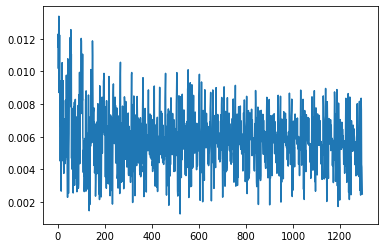

In [854]:
plt.plot(ve_list)

In [855]:
print(metrics.classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

         <30       1.00      0.45      0.62      7932
          NO       0.94      1.00      0.97     63304

    accuracy                           0.94     71236
   macro avg       0.97      0.73      0.80     71236
weighted avg       0.94      0.94      0.93     71236



In [856]:
print(metrics.classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

         <30       0.37      0.01      0.02      3425
          NO       0.89      1.00      0.94     27105

    accuracy                           0.89     30530
   macro avg       0.63      0.50      0.48     30530
weighted avg       0.83      0.89      0.84     30530



In [857]:
metrics.roc_auc_score(pd.DataFrame(y_test)['readmitted'].replace(['<30','NO'],[1,0]),pd.DataFrame(y_pred_test)[0].replace(['<30','NO'],[1,0]))

0.5041302208093155

In [858]:
metrics.confusion_matrix(y_test,y_pred_test)

array([[   36,  3389],
       [   61, 27044]], dtype=int64)

In [669]:
rf_cv = cross_val_score(rf,X,y,cv=folds,scoring='roc_auc')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    2.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    3.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of 

In [670]:
print("Avg AUC: ",np.mean(rf_cv))
print("Bias Error:",1-np.mean(rf_cv))
print("Variance Error:",np.std(rf_cv,ddof=1))

Avg AUC:  0.6122492570898878
Bias Error: 0.38775074291011224
Variance Error: 0.001068827964347718


### Models without parameter tuning

In [1132]:
lr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
nb = GaussianNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
bag = BaggingClassifier()
ada = AdaBoostClassifier()

In [1133]:
models = [lr,knn,nb,dt,rf,gb,bag,ada]

In [1138]:
X.shape

(101766, 67)

In [1134]:
cv_score = []
for model in models:
    cv = cross_val_score(model,X,y,cv=folds,scoring='roc_auc')
    cv_score.append(cv)

In [1135]:
models_auc = pd.DataFrame({'model':models,'cv':cv_score,'avg_auc':np.mean(cv_score,axis=1)})
models_auc

model  \
0  LogisticRegression(max_iter=1000)   
1             KNeighborsClassifier()   
2                       GaussianNB()   
3           DecisionTreeClassifier()   
4           RandomForestClassifier()   
5       GradientBoostingClassifier()   
6                BaggingClassifier()   
7               AdaBoostClassifier()   

                                                  cv   avg_auc  
0  [0.6508384951006538, 0.656840574544608, 0.6502...  0.655177  
1  [0.5574005352338028, 0.5610070419916362, 0.558...  0.558312  
2  [0.6042403047968511, 0.6159498381853579, 0.618...  0.612582  
3  [0.5284098908747118, 0.5245924811369187, 0.527...  0.526717  
4  [0.6297567506756939, 0.6397554621195327, 0.633...  0.634189  
5  [0.6647388858574461, 0.6697917828781226, 0.665...  0.668529  
6  [0.5859452581792723, 0.593984182685133, 0.5945...  0.590587  
7  [0.6579693575703895, 0.665682908017516, 0.6552...  0.661321

In [1136]:
cv_score[0]

array([0.6508385 , 0.65684057, 0.65022275, 0.65851786, 0.65946683])

In [1137]:
cv_score[5]

array([0.66473889, 0.66979178, 0.66573652, 0.67175301, 0.67062488])

In [1139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [1140]:
for model in models:
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print('Model: ',model)
    print("\n Train\n---------------")
    print(metrics.roc_auc_score(y_train,y_pred_train))
    print("\n Test\n---------------")
    print(metrics.roc_auc_score(y_test,y_pred_test))
    print("\n Confusion Matrix\n----------")
    print(metrics.confusion_matrix(y_test,y_pred_test))

Model:  LogisticRegression(max_iter=1000)

 Train
---------------
0.5

 Test
---------------
0.5

 Confusion Matrix
----------
[[27108     0]
 [ 3422     0]]
Model:  KNeighborsClassifier()

 Train
---------------
0.5532967248516795

 Test
---------------
0.509925706184505

 Confusion Matrix
----------
[[26648   460]
 [ 3296   126]]
Model:  GaussianNB()

 Train
---------------
0.5274874257514435

 Test
---------------
0.521261351545999

 Confusion Matrix
----------
[[ 2539 24569]
 [  175  3247]]
Model:  DecisionTreeClassifier()

 Train
---------------
0.9999369880277253

 Test
---------------
0.5237060071940305

 Confusion Matrix
----------
[[23664  3444]
 [ 2825   597]]
Model:  RandomForestClassifier()

 Train
---------------
0.9998109640831758

 Test
---------------
0.503374718973749

 Confusion Matrix
----------
[[27085    23]
 [ 3396    26]]
Model:  GradientBoostingClassifier()

 Train
---------------
0.5080253258735106

 Test
---------------
0.5061280949324334

 Confusion Matrix
--